
# 🧠 Nilearn GLM Tutorial — From Events to Contrasts (with real NARPS data)

This notebook is a step-by-step introduction to **task-fMRI statistical modeling** using **Nilearn**, a Python library for neuroimaging analysis.

Our goal is simple:

> 🎯 **Start from a preprocessed fMRI run + an events table, and end with statistical maps answering scientific questions (contrasts).**


### ✅ What you will learn

By the end of this notebook, you will be able to:

* 🧠 understand what the BOLD signal is (and what it is *not*)
* 📦 read and interpret fMRI data stored as **4D NIfTI images**
* 🗂️ understand the role of **events.tsv** and **confounds.tsv**
* 🧩 build **HRF-convolved regressors** from event timings
* 🧱 build a full **design matrix** (task + drifts + confounds + intercept)
* 📈 fit a **FirstLevelModel** (voxelwise GLM)
* 🧪 compute and interpret **contrasts** (t-maps / z-maps)
* 🔍 inspect a **diagnostic map** (voxelwise (R^2)) to evaluate model fit



### Dataset used in this notebook 

We use a public dataset from **NARPS** (*Neuroimaging Analysis Replication and Prediction Study*). The NARPS project is famous because it showed that **many labs analyzing the same dataset can obtain different results**, depending on modeling decisions.

### Task: Mixed Gambles (MGT)

On each trial, participants see:

* a **potential gain** (e.g. +12)
* a **potential loss** (e.g. -6)

They choose whether to accept the gamble, with 4 response levels:

* `strongly_accept`
* `weakly_accept`
* `weakly_reject`
* `strongly_reject`

The trial-level behavioral data is stored in an **events.tsv** file.

### What we download (minimal subset)

To keep runtime low and make the tutorial reproducible, we restrict the data to:

* 👤 **2 subjects**: `sub-001` and `sub-003`
* ▶️ **1 run** per subject: `run-01`
* 🌍 **preprocessed BOLD** images already in **MNI space**
* 🧠 the corresponding **brain mask**, **events.tsv**, and **confounds.tsv**



### Files you will see (and what they mean)

This notebook uses two main data types:

* 🧊 NIfTI images (`.nii.gz`)

These store the actual fMRI signal.

  * BOLD file: `*_preproc.nii.gz`
  **4D image** shaped like:

  $$
  (n_x, n_y, n_z, T)
  $$

  * Mask file: `*_brainmask.nii.gz`
  **3D image** that defines which voxels belong to the brain.

* 📑 TSV tables (`.tsv`)

These store time-aligned metadata:

  * `*_events.tsv`
  timing + trial information (onset/duration, gain/loss, response, etc.)

  * `*_confounds.tsv`
  nuisance regressors produced by fMRIPrep (motion, outliers, physiological components…)


### A concrete view of the data we will work with

When we load our example run (`sub-001`, `run-01`), we will find:

* ⏱️ **TR** = 1.0 second
* 🧱 **T** = 453 volumes (time points)

So our run lasts about:

[
453 \times 1.0 \approx 453 \text{ seconds} \ (\approx 7.5 \text{ minutes})
]

And the **events** table contains trial entries like:

| onset (s) | duration (s) | gain | loss |    RT | participant_response |
| --------: | -----------: | ---: | ---: | ----: | -------------------- |
|     4.071 |            4 |   14 |    6 | 2.388 | weakly_accept        |
|    11.834 |            4 |   34 |   14 | 2.289 | strongly_accept      |
|         … |            … |    … |    … |     … | …                    |


------------------------

# Part 1 — Foundations of fMRI

## 1. Functional MRI and the BOLD signal

### 1.1 What fMRI measures

Functional Magnetic Resonance Imaging (fMRI) is a neuroimaging technique that measures brain activity **indirectly** through changes in blood oxygenation.
Unlike electrophysiological methods (EEG, MEG), fMRI does **not** measure neural firing itself. Instead, it relies on the **Blood-Oxygen-Level-Dependent (BOLD)** contrast.

When a population of neurons becomes active, several coupled processes occur:

1. Neuronal firing increases metabolic demand (oxygen and glucose)
2. Local cerebral blood flow increases disproportionately
3. The concentration of deoxygenated hemoglobin decreases
4. This change alters the local magnetic susceptibility
5. The MRI signal intensity changes accordingly

The measured fMRI signal therefore reflects **vascular and metabolic responses** to neural activity, not neural activity itself.



### 1.2 Physical origin of the BOLD contrast

The BOLD effect arises from the magnetic properties of hemoglobin:

* **Oxygenated hemoglobin (HbO)** is diamagnetic
* **Deoxygenated hemoglobin (HbR)** is paramagnetic

An increase in HbR introduces local magnetic field inhomogeneities, accelerating T2* signal decay and reducing MRI signal intensity.
Conversely, a decrease in HbR leads to a relative signal increase.

In most experimental conditions, neural activation causes an **overcompensatory increase in blood flow**, resulting in a net **increase in BOLD signal**.



### 1.3 Temporal characteristics of the BOLD response

A key property of the BOLD signal is its **slow temporal dynamics**.

Typical timeline following a brief neural event:

* Initial delay: ~1–2 seconds
* Peak response: ~5–6 seconds
* Return to baseline: ~12–20 seconds
* Post-stimulus undershoot: up to ~30 seconds

This temporal smoothing implies that fMRI has:

* **High spatial resolution**
* **Low temporal resolution**

Neural events occurring close in time produce **overlapping BOLD responses**, which complicates temporal disentanglement and motivates explicit modeling of the response shape.



### 1.4 Consequences for data analysis

Because fMRI measures a delayed and blurred response:

* Neural activity cannot be read directly from the signal
* Statistical models must incorporate assumptions about the temporal response
* Interpretation of timing and amplitude must be done cautiously

This motivates the introduction of an explicit model of the BOLD response to neural events: the **Hemodynamic Response Function (HRF)**, which will be introduced in Part II.





## 2. Structure of fMRI data

### 2.1 BOLD fMRI data and NIfTI representation

Functional MRI measures the **BOLD (Blood-Oxygen-Level-Dependent) signal**, which reflects changes in blood oxygenation over time.
The term *BOLD* refers to the **type of contrast** measured by the scanner, not to a file format.

![Description](assets/4Ddata.png)



In practice, BOLD fMRI data is stored as a **4-dimensional volume** using the **NIfTI format**.

A BOLD fMRI dataset therefore has the following structure:

```
(x, y, z, t)
```

where:

* (x, y, z) are spatial dimensions (voxels)
* (t) indexes time (acquired volumes)

Each time point corresponds to one whole-brain BOLD image acquired every repetition time (TR), typically between 0.5 and 3 seconds.



### 2.2 Voxel-wise fMRI time series

Each voxel in a BOLD NIfTI file contains a **time series** representing the evolution of the BOLD signal at that spatial location:

```
y = [y1, y2, ..., yT]
```

where:

* (yt) is the BOLD signal at time point t
* (T) is the total number of acquired volumes

At this stage, the signal is typically noisy and dominated by physiological and scanner-related fluctuations.
Task-related effects are not directly visible and must be extracted through statistical modeling.



### 2.3 Raw and preprocessed BOLD data

BOLD fMRI data exists at different stages of processing:

**Raw BOLD data**

* Acquired directly from the MRI scanner
* Contains artifacts such as head motion, susceptibility distortions, and slice timing effects
* Usually not suitable for statistical analysis

**Preprocessed BOLD data**

* Corrected for major artifacts
* Spatially normalized to a reference space
* Optionally smoothed or filtered
* Still represents the same underlying BOLD signal

A widely used preprocessing pipeline is **fMRIPrep**, which takes raw BOLD data as input and produces **analysis-ready BOLD NIfTI files**, along with accompanying metadata.



### 2.4 Experimental timing information (events)

In task-based fMRI, the experimental paradigm is described separately from the imaging data using **event files**, typically stored in TSV format.

An events file contains, at minimum:

* **onset**: start time of the event (in seconds)
* **duration**: length of the event (in seconds)
* **trial_type**: condition label

Optionally, it may also include:

* **modulation**: parametric value associated with the event (e.g. stimulus intensity)

Crucially, event timings are expressed in **continuous time (seconds)** rather than scan indices.
This allows experimental timing to be combined consistently with different TR values and sampling schemes.



### 2.5 Confounds and nuisance variables

In addition to task-related effects, fMRI data contains structured noise sources, including:

* Head motion
* Scanner drift
* Physiological fluctuations (cardiac, respiratory)
* Signal instabilities at the beginning of runs

These effects are summarized in **confound regressors**, provided as time series aligned with the fMRI volumes.

Each confound regressor has exactly (T) rows, matching the number of acquired volumes, and is included in the statistical model to explain variance unrelated to the experimental hypothesis.



### 2.6 Brain masks and analysis space

Statistical analyses are usually restricted to a subset of voxels defined by a **brain mask**, excluding non-brain regions and low-signal voxels.

Additionally, data are commonly analyzed in a **standard reference space** (e.g. MNI), especially for group-level analyses.
Spatial normalization ensures voxel-wise correspondence across subjects and enables population-level inference.



---

# Part 2 — Hemodynamic modeling (HRF and convolution)

## 1. Modeling the BOLD response to neural events
From events to regressors
In task-based fMRI, experimental events occur at precise times (onset/duration), but the measured BOLD signal evolves slowly over seconds.
To link events (neural hypotheses) to observed fMRI data, we introduce a model of the BOLD response to a brief neural input.

This model is called the **Hemodynamic Response Function (HRF)**.


### **Intuition: why do we need an HRF?**

If a stimulus happens at time t0:

* the brain’s neural response is fast (milliseconds)
* the BOLD response is delayed and spread over time (seconds)

So a single event does **not** produce a spike in the BOLD signal.
It produces a smooth curve:

* delayed rise
* peak around ~5s
* slow return to baseline
* possible undershoot

The HRF is a template describing this typical shape.


### **Canonical HRF: a practical approximation**

The true HRF varies across subjects, brain regions, and acquisition settings.
However, most statistical pipelines start with a **canonical HRF**: a standard shape used as a reasonable approximation.

A common canonical HRF (used in SPM and available in Nilearn as “glover”) can be expressed as the difference of two gamma-like components:

* a positive component (main response)
* a negative component (undershoot)


We model the HRF as:

```
HRF(t) = gamma_pos(t) - ratio * gamma_neg(t)
```

where:

* gamma_pos(t) models the main peak
* gamma_neg(t) models the delayed undershoot
* ratio controls the undershoot amplitude relative to the peak


> The canonical HRF can be approximated as a weighted difference between a positive gamma (main response) and a negative gamma (undershoot). This shape models the delayed and smoothed vascular response to a brief neural event.

<img src="assets/hrf_gamma.gif" width="600">



## 2. From events to regressors


### **What an “event regressor” means**

Before convolution, events are described as:

* onset (seconds)
* duration (seconds)
* amplitude (optional)

Conceptually, this defines a time function that is “active” during the event and zero otherwise.

This event function is not yet in “BOLD space” — it represents the hypothesized neural timing.

⚠️ **Important:**
An “event” does not have to correspond to a physical stimulus.
It can represent any time point at which a specific neural process is hypothesized to occur, such as a behavioral response, a decision, a button press, or feedback presentation.

In all cases, the event regressor encodes a hypothesis about *when* a neural process of interest occurs, independently of how it is triggered.



### **Why convolution is the key step**

The central idea is:

> Each event produces an HRF-shaped BOLD response.
> If multiple events occur, their BOLD responses overlap and add up.

This is modeled mathematically via **convolution**.


If:

* s(t) is the event function (neural hypothesis)
* h(t) is the HRF

then the predicted BOLD signal x(t) is:

```
x(t) = (s * h)(t)
```

Meaning:

* for each event time, place a copy of the HRF
* sum all copies across events
* the result is a smooth regressor aligned with the scan timeline

<img src="assets/hrf_convolution.gif" width="600">


> Convolution turns discrete neural events into a continuous predicted BOLD regressor by summing HRF-shaped responses at each event onset. When events are close in time, responses overlap.


### **HRF models in Nilearn**

Nilearn provides HRF models through the module:

* `nilearn.glm.first_level.hemodynamic_models`

Common HRF options include:

* glover: Canonical HRF (Glover). A standard smooth shape used widely; good default.
* spm: Canonical HRF used by SPM (very similar in spirit to Glover, slightly different parameterization). Often chosen for compatibility with SPM-like pipelines.
* versions with derivatives: Adds the temporal derivative of the canonical HRF.
Intuition: lets the model handle small timing shifts (peak happens slightly earlier/later than the canonical HRF).
* FIR models (finite impulse response): No fixed HRF shape is assumed. Instead the response is estimated as a set of time-bin coefficients.
Intuition: maximum flexibility, but more parameters → needs more data and careful design.

In practice, in Nilearn you don’t always pass the HRF as a numeric vector.
You typically specify it using a string such as:

* `"glover"`
* `"glover + derivative"`
* `"glover + derivative + dispersion"`

<img src="assets/hrf_types.png" width="600">




### **Discretization: frame times and TR alignment**

fMRI data is sampled at discrete time points (each volume acquisition).
To generate regressors compatible with the data, the predicted signal must be evaluated at the scan time grid.

Define:

* T = number of volumes
* TR = repetition time (seconds)

Then we build a time grid called `frame_times`, containing one time value per volume.

These frame times are the link between:

* continuous event timings (seconds)
* discrete data sampling (volumes)

This is why Nilearn requires `frame_times` when building regressors.


### **Computing regressors in Nilearn**

At a low level, Nilearn constructs regressors using:

* event specification (onset, duration, amplitude)
* HRF model choice
* frame_times

Conceptually:

* input: events in seconds
* process: convolution + sampling
* output: regressor as a column vector of length T

This output is exactly what will become one column of the design matrix in the next part.


---


# Part 3 — Introductionto the Nilearn Library (importing data/HRF & regressors)


## 1. Importing the data locally

In this section, we prepare a **minimal, analysis-ready fMRI dataset** that will be used throughout the rest of the notebook for concrete demonstrations.

Specifically, we:

- 📦 **Download an open-access fMRI dataset** (NARPS study) from OpenNeuro  
- 👥 **Restrict the download to a small subset of subjects**  
  → only **two subjects** (`sub-001` and `sub-003`)  
  → only **one run** (`run-01`) per subject  
- 🧠 **Use preprocessed BOLD data**, not raw scanner data  

#### Type of data downloaded

The downloaded data includes:

- **Preprocessed BOLD fMRI images** (`*_preproc.nii.gz`)  
  - 4D NIfTI files `(x, y, z, t)`
  - Spatially normalized to **MNI space**
- **Brain masks** (`*_brainmask.nii.gz`)
- **Event files** (`*_events.tsv`)
  - Onsets, durations, and condition labels
- **Confound regressors** (`*_confounds.tsv`)
  - Motion parameters and other nuisance variables


⚠️ **The BOLD data used here has already been preprocessed using _fMRIPrep_.**

This means that major corrections have already been applied, including:

- motion correction  
- susceptibility distortion correction  
- spatial normalization  
- intensity normalization  

👉 **We do NOT perform preprocessing in this notebook.**  
The focus here is strictly on:

- understanding the structure of fMRI data  
- building regressors  
- constructing design matrices  
- fitting statistical models  




In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# Prevent numpy from hogging all CPUs in some environments
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"


# ============================================================
# Everything goes under ./data/NARPS relative to the notebook
# ============================================================
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "data" / "NARPS"
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("📂 Notebook folder:", PROJECT_DIR)
print("📦 Data directory:", DATA_DIR)


# ============================================================
# INSTALL (only if needed)
# ============================================================
def ensure_package(pkg: str):
    try:
        __import__(pkg)
        print(f"✅ {pkg} already installed")
    except ImportError:
        print(f"⬇️ Installing {pkg} ...")
        import sys
        !{sys.executable} -m pip install -q {pkg}
        print(f"✅ {pkg} installed")

ensure_package("nilearn")
ensure_package("awscli")


# ============================================================
# DOWNLOAD NARPS subset (OpenNeuro S3) — safe skip if present
#    This downloads:
#    - fmriprep preproc nifti for sub-001 and sub-003 (run-01 MNI)
#    - associated .tsv confounds
#    - events.tsv
# ============================================================
# We'll consider "downloaded" if we have at least this file:
CHECK_FILE = DATA_DIR / "derivatives" / "fmriprep" / "sub-001" / "func" / \
    "sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"

if CHECK_FILE.exists():
    print("✅ Data already present — skipping download.")
else:
    print("⬇️ Downloading NARPS subset into:", DATA_DIR)
    save_dir = str(DATA_DIR)

    # Preprocessed nifti (MNI space) for sub-001 and sub-003, run-01
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} \
        --exclude "*" \
        --include "*fmriprep/sub-00[1,3]/func/*run-01*space-MNI*.nii.gz"

    # Confounds TSV (and other TSVs in fmriprep folder for those subs/runs)
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} \
        --exclude "*" \
        --include "*fmriprep/sub-00[1,3]/func/*run-01*.tsv"

    # Events TSV
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} \
        --exclude "*" \
        --include "*sub-00[1,3]/func/*run-01*events.tsv"

    print("✅ Download done!")

📂 Notebook folder: /volatile/home/sb283337/Bureau/fmri_intro
📦 Data directory: /volatile/home/sb283337/Bureau/fmri_intro/data/NARPS
✅ nilearn already installed
✅ awscli already installed
✅ Data already present — skipping download.


## 2. Load the needed data for the tutorial

Now that the data is available locally, we will **load the core files needed for the next part*:

- 🧠 **BOLD fMRI time series** (4D NIfTI): the signal we want to model  
- 🏷️ **Events file** (`events.tsv`): timing + conditions of the experiment  
- 🧹 **Confounds file** (`confounds.tsv`): nuisance regressors (e.g., motion)

What we will do here

1. Pick **one subject** and **one run** (to keep it simple)
2. Load the BOLD image and extract:
   - number of volumes (**T**)
   - repetition time (**TR**)
3. Load `events.tsv` and inspect the columns
4. Load `confounds.tsv` and select a **small standard subset** (motion + non-steady-state)

We will have `fmri_img`, `events_df`, `confounds_df`, and the basic timing info (`TR`, `n_vols`), ready for regressor / design matrix construction.


In [2]:
# ============================================================
# LOAD ONE SUBJECT/RUN (sub-001 run-01)
# ============================================================
fmri_path = DATA_DIR / "derivatives" / "fmriprep" / "sub-001" / "func" / \
    "sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"

mask_path = DATA_DIR / "derivatives" / "fmriprep" / "sub-001" / "func" / \
    "sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz"

events_path = DATA_DIR / "sub-001" / "func" / "sub-001_task-MGT_run-01_events.tsv"

conf_path = DATA_DIR / "derivatives" / "fmriprep" / "sub-001" / "func" / \
    "sub-001_task-MGT_run-01_bold_confounds.tsv"

print("📌 fmri_path:", fmri_path)
print("📌 mask_path:", mask_path)
print("📌 events_path:", events_path)
print("📌 conf_path:", conf_path)

fmri_img = nib.load(str(fmri_path))
tr = fmri_img.header.get_zooms()[3]
n_vols = fmri_img.shape[3]
print(f"📌 TR={tr} sec | n_vols={n_vols}")

events_df = pd.read_csv(events_path, sep="\t")
confounds_df = pd.read_csv(conf_path, sep="\t")

display(events_df.head())
display(confounds_df.head())



📌 fmri_path: /volatile/home/sb283337/Bureau/fmri_intro/data/NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
📌 mask_path: /volatile/home/sb283337/Bureau/fmri_intro/data/NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
📌 events_path: /volatile/home/sb283337/Bureau/fmri_intro/data/NARPS/sub-001/func/sub-001_task-MGT_run-01_events.tsv
📌 conf_path: /volatile/home/sb283337/Bureau/fmri_intro/data/NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_confounds.tsv
📌 TR=1.0 sec | n_vols=453


,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
3,27.535,4,10,10,1.457,weakly_reject
4,36.435,4,12,19,1.973,strongly_reject


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine03,Cosine04,Cosine05,NonSteadyStateOutlier00,X,Y,Z,RotX,RotY,RotZ
0,6551.2820,6476.4653,9874.576,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000
1,6484.7285,6473.4890,9830.212,1.090467,52.782734,1.059437,0.135279,0.026310,-0.067307,0.093488,...,0.066513,0.066509,0.066505,0.0,-0.009969,-0.031344,-0.000003,0.001327,-3.841930e-04,-0.000168
2,6441.5337,6485.7256,9821.212,1.075201,52.043827,1.038219,0.124377,-0.040482,0.034151,0.136612,...,0.066461,0.066429,0.066389,0.0,-0.000026,-0.009237,0.054967,0.000997,-1.974500e-04,-0.000399
3,6401.1150,6481.4287,9808.847,1.054436,51.038681,1.024683,0.141592,0.041604,0.043600,0.019408,...,0.066358,0.066268,0.066158,0.0,-0.000033,0.057941,0.069283,0.000115,-3.759120e-24,-0.000277
4,6428.2754,6486.5215,9800.982,1.033018,50.001972,1.008018,0.050009,0.039142,-0.048557,0.002349,...,0.066204,0.066028,0.065812,0.0,-0.000028,0.066681,0.047148,-0.000131,-0.000000e+00,-0.000140


## 3. Build one HRF-convolved regressor (low-level)

Before building a full design matrix, we first build **one single regressor** manually.

This demonstrates what a “regressor” actually is:

- start from **event timings** (onset, duration, amplitude)
- choose an **HRF model**
- perform **convolution + sampling**
- obtain a predicted BOLD time series aligned with the scan


Here, we build a regressor for a single condition:

- `participant_response == "strongly_accept"`


📌 condition: strongly_accept
📌 number of events: 26
📌 frame_times shape: (453,)
📌 exp_condition shape: (3, 26)
📌 reg shape: (453, 1)
📌 reg_name: ['cond']


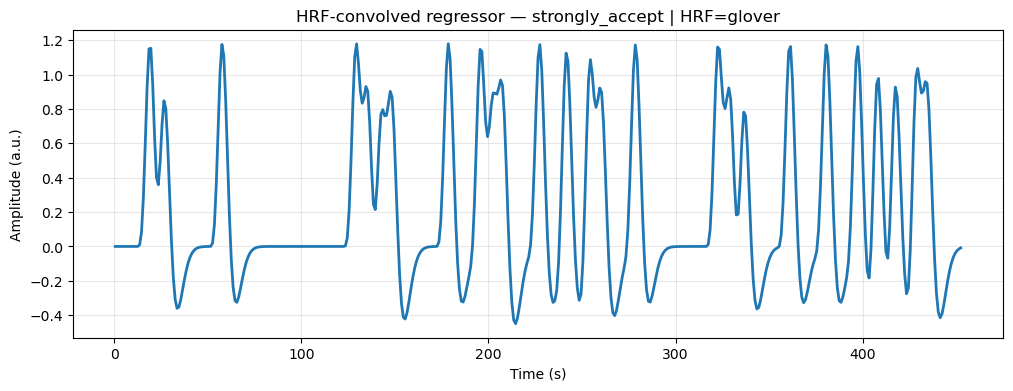

In [3]:
# ============================================================
# LOW-LEVEL REGRESSOR (compute_regressor)
# ============================================================
from nilearn.glm.first_level.hemodynamic_models import compute_regressor

# ---- choose one condition
cond_name = "strongly_accept"
idx = events_df["participant_response"] == cond_name

cond_events = events_df.loc[idx, ["onset", "duration"]].copy()
cond_events["amplitude"] = 1.0  # constant weight for all events

exp_condition = cond_events[["onset", "duration", "amplitude"]].values.T  # shape (3, N)
frame_times = np.arange(n_vols) * tr + tr / 2


print("📌 condition:", cond_name)
print("📌 number of events:", exp_condition.shape[1])
print("📌 frame_times shape:", frame_times.shape)
print("📌 exp_condition shape:", exp_condition.shape)

# ---- HRF model
hrf_model = "glover"  # try also: "spm", "glover + derivative", ...

# ---- compute regressor
reg, reg_name = compute_regressor(
    exp_condition=exp_condition,
    hrf_model=hrf_model,
    frame_times=frame_times
)

print("📌 reg shape:", reg.shape)
print("📌 reg_name:", reg_name)

# ---- plot
plt.figure(figsize=(12, 4))
plt.plot(frame_times, reg, linewidth=2)
plt.title(f"HRF-convolved regressor — {cond_name} | HRF={hrf_model}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True, alpha=0.3)
plt.show()


## 4. Parametric modulation regressor (optional)

Sometimes we do not only want an “event vs baseline” regressor.

We want to test whether brain activity scales with a continuous variable.

Example in NARPS:
- each trial has a **gain amount**
- we can build a regressor whose amplitude is modulated by this gain

Key point:
- modulation values should usually be **mean-centered**
  (so the baseline regressor remains interpretable)

✅ Output of this part:
- `parametric_gain_reg`: HRF-convolved regressor modulated by gain


📌 parametric_gain_reg shape: (453, 1)


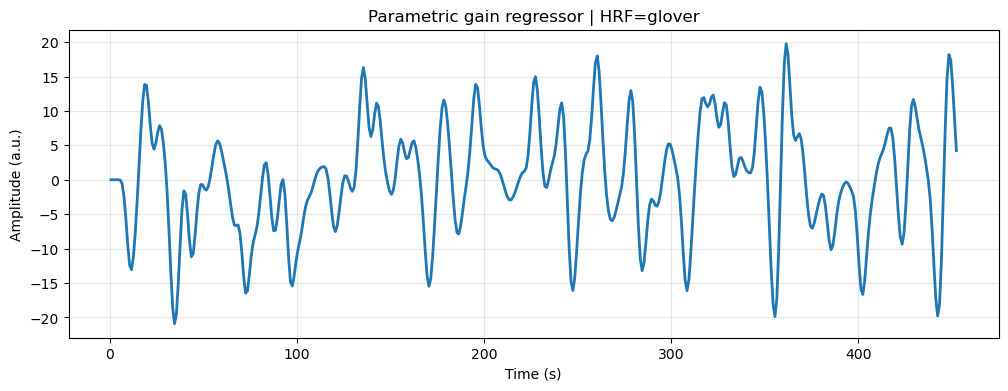

In [4]:
# ============================================================
# PARAMETRIC MODULATION (gain)
# ============================================================
gain_events = events_df[["onset", "duration", "gain"]].copy()

# Mean-center gain
gain_events["modulation"] = gain_events["gain"] - gain_events["gain"].mean()

# Build exp_condition = (onset, duration, modulation)
gain_condition = gain_events[["onset", "duration", "modulation"]].values.T

parametric_gain_reg, _ = compute_regressor(
    exp_condition=gain_condition,
    hrf_model=hrf_model,
    frame_times=frame_times
)

print("📌 parametric_gain_reg shape:", parametric_gain_reg.shape)

plt.figure(figsize=(12, 4))
plt.plot(frame_times, parametric_gain_reg, linewidth=2)
plt.title(f"Parametric gain regressor | HRF={hrf_model}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True, alpha=0.3)
plt.show()


---

# Part 4 — Design matrices in task-based fMRI

## 1. Why do we need a design matrix?

In task-based fMRI, we want to **explain the observed BOLD signal** at each voxel using a statistical model.

At a high level, for a single voxel, we write:

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}
$$

where:

* **𝒚** is the observed BOLD time series (length *T*)
* **𝑿** is the **design matrix**
* **β** are regression coefficients
* **ε** is noise

👉 The **design matrix encodes our hypotheses** about how brain activity should evolve over time.


## 2 What is a design matrix?

A **design matrix** is a 2D matrix of shape:

$$
(T \times P)
$$

where:

* **T** = number of fMRI volumes (time points)
* **P** = number of regressors (predictors)

Each column represents **one explanatory variable**, such as:

* a task condition (HRF-convolved)
* a parametric modulation
* a nuisance regressor (motion, drift, etc.)
* a constant (intercept)

Each row corresponds to **one acquired fMRI volume**.



## 3. From events to regressors (recap)

Before building a design matrix, we already constructed **individual regressors**.

Each regressor was built by:

1. Defining **events** in continuous time (onset, duration, amplitude)
2. Convolving them with an **HRF**
3. Sampling the result at **frame_times**

This gave us a vector:

$$
\mathbf{x}_p \in \mathbb{R}^{T}
$$


⚠️ **Important:**
A single regressor is **not** a design matrix.

The design matrix is obtained by **stacking multiple regressors column-wise**.



## 4. What goes into a design matrix?

A typical first-level design matrix includes:

### Task-related regressors

* One regressor per condition
* Optionally parametric modulators

### Nuisance regressors

* Head motion (translations + rotations)
* Scanner drift
* Physiological noise (if available)

### Intercept

* A constant column (models the baseline signal)



## 5. Low-level vs high-level construction in Nilearn

Nilearn offers **two ways** to build a design matrix:

### Low-level (manual, flexible)

* Use `compute_regressor`
* Stack columns yourself

### High-level (recommended)

* Use `make_first_level_design_matrix`
* Handles:

  * HRF convolution
  * condition separation
  * intercept
  * optional drifts

👉 In this notebook, we use the **high-level interface**, but only **after understanding the low-level mechanics**.

---

# Part 5 — Building a design matrix with Nilearn


We now build a **full design matrix** using:

* `events.tsv`
* `frame_times`
* an HRF model



## 1. Prepare the events table

Nilearn expects an events DataFrame with **specific column names**:

| column                | meaning                  |
| --------------------- | ------------------------ |
| onset                 | event start (seconds)    |
| duration              | event duration (seconds) |
| trial_type            | condition label          |
| modulation (optional) | parametric weight        |

Let’s adapt our events file.

In [5]:
# ============================================================
# Prepare events for design matrix
# ============================================================

events_dm = events_df.loc[:, ["onset", "duration", "participant_response"]].copy()

# Nilearn expects the column name "trial_type"
events_dm = events_dm.rename(
    columns={"participant_response": "trial_type"}
)

# Optional: remove trials with no response
events_dm = events_dm.query("trial_type != 'NoResp'")

# No parametric modulation here → set to 1
events_dm["modulation"] = 1.0

display(events_dm.head())

,onset,duration,trial_type,modulation
0,4.071,4,weakly_accept,1.0
1,11.834,4,strongly_accept,1.0
2,19.535,4,strongly_accept,1.0
3,27.535,4,weakly_reject,1.0
4,36.435,4,strongly_reject,1.0


## 2. Build the design matrix

Now we call Nilearn’s high-level function.

In [6]:
from nilearn.glm.first_level.design_matrix import make_first_level_design_matrix

dm = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events_dm,
    hrf_model="glover",
    drift_model=None   # we will discuss drifts later
)

print("📌 Design matrix shape:", dm.shape)
dm.head(10)

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.
📌 Design matrix shape: (453, 5)


,strongly_accept,strongly_reject,weakly_accept,weakly_reject,constant
0.5,0.0,0.0,0.000000,0.0,1.0
1.5,0.0,0.0,0.000000,0.0,1.0
2.5,0.0,0.0,0.000000,0.0,1.0
3.5,0.0,0.0,0.000000,0.0,1.0
4.5,0.0,0.0,0.000003,0.0,1.0
5.5,0.0,0.0,0.003865,0.0,1.0
6.5,0.0,0.0,0.054358,0.0,1.0
7.5,0.0,0.0,0.222149,0.0,1.0
8.5,0.0,0.0,0.512188,0.0,1.0
9.5,0.0,0.0,0.851532,0.0,1.0


## 3. Visualize the design matrix


<Axes: label='conditions', ylabel='scan number'>

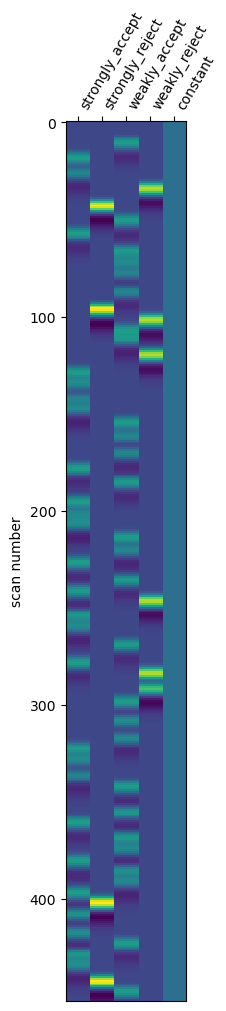

In [7]:
from nilearn.plotting import plot_design_matrix

plot_design_matrix(dm)

### How to read this plot

* **Columns** → regressors
* **Rows** → time points
* **Brighter color** → higher regressor value

This visualization is crucial to:

* detect collinearity
* verify event timing
* catch design mistakes early


#### Important conceptual clarification ⚠️

> **Regressor ≠ Design Matrix**

* A **regressor** is a single column
* A **design matrix** is a structured collection of regressors

Mathematically:

$$
\mathbf{X} = [\mathbf{x}_1 ; \mathbf{x}_2 ; \dots ; \mathbf{x}_P]
$$

Nilearn builds this matrix **for you**, but you must understand:

* what each column represents
* what assumptions you are encoding

---




# Part 6 — Enriching the design matrix: drifts and confounds

In the previous sections, we constructed **task-related regressors** by convolving experimental events with an HRF and sampling them at the fMRI acquisition times.

These regressors already encode important hypotheses about **when task-related neural processes may occur**.

However, a realistic fMRI design matrix almost never contains **only** task regressors.


## 1. Why a task-only design matrix is insufficient

The BOLD signal measured in fMRI is influenced by many factors beyond the experimental paradigm.

In particular, fMRI time series typically exhibit:

* slow fluctuations unrelated to the task (scanner drift)
* head motion–related signal changes
* instabilities at the beginning of a run
* other structured noise sources

If these effects are **not represented in the design matrix**, they may:

* overlap with task regressors
* distort task-related estimates later on
* reduce interpretability of results

👉 The goal of this section is **not** to remove these effects from the data,
but to **explicitly encode them as additional columns in the design matrix**.


## 2. Conceptual structure of an extended design matrix

At this stage, the design matrix can be viewed purely as a **collection of predictor time courses**:

$$
\mathbf{X}
=
\big[
\mathbf{X}*{\text{task}}
;
\mathbf{X}*{\text{nuisance}}
;
\mathbf{1}
\big]
$$

where:

* $\mathbf{X}_{\text{task}}$ contains task-related regressors
* $\mathbf{X}_{\text{nuisance}}$ contains regressors modeling unwanted variability
* $\mathbf{1}$ is a constant column (intercept)

⚠️ At this point, this equation is **descriptive**, not inferential.
We are defining **what signals are allowed to explain the data over time**, not estimating their effects yet.


## 3. Temporal drifts: modeling slow fluctuations

### What are temporal drifts?

fMRI signals often contain **very slow fluctuations** that evolve over tens or hundreds of seconds.

These fluctuations can arise from:

* scanner instabilities
* slow physiological processes
* thermal effects

They typically dominate the **lowest frequencies** of the signal and are unrelated to experimental events.


### How drifts are represented in a design matrix

Instead of filtering the data directly, we represent these slow trends by adding **drift regressors** to the design matrix.

In Nilearn, this is typically done using a **cosine basis**, controlled by:

* `drift_model="cosine"`
* `high_pass=0.01` (in Hz)

This means:

* only fluctuations **slower than ~100 seconds** are modeled as drifts
* faster variations (including task effects) are preserved

Each drift regressor becomes **one additional column** in the design matrix.



## 5. Building an enriched design matrix in Nilearn

We now construct a design matrix that includes:

* task-related regressors
* drift regressors
* an intercept

Confounds will be supplied later, together with this design matrix, when fitting a statistical model.

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.
📐 Design matrix shape: (453, 14)


,strongly_accept,strongly_reject,weakly_accept,weakly_reject,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,constant
0.5,0.0,0.0,0.000000,0.0,0.066445,0.066444,0.066442,0.066439,0.066436,0.066431,0.066426,0.066420,0.066413,1.0
1.5,0.0,0.0,0.000000,0.0,0.066442,0.066431,0.066413,0.066388,0.066356,0.066316,0.066269,0.066216,0.066155,1.0
2.5,0.0,0.0,0.000000,0.0,0.066436,0.066406,0.066356,0.066286,0.066196,0.066086,0.065957,0.065807,0.065638,1.0
3.5,0.0,0.0,0.000000,0.0,0.066426,0.066367,0.066269,0.066133,0.065957,0.065742,0.065489,0.065197,0.064866,1.0
4.5,0.0,0.0,0.000003,0.0,0.066413,0.066316,0.066155,0.065929,0.065638,0.065284,0.064866,0.064385,0.063842,1.0


<Axes: label='conditions', ylabel='scan number'>

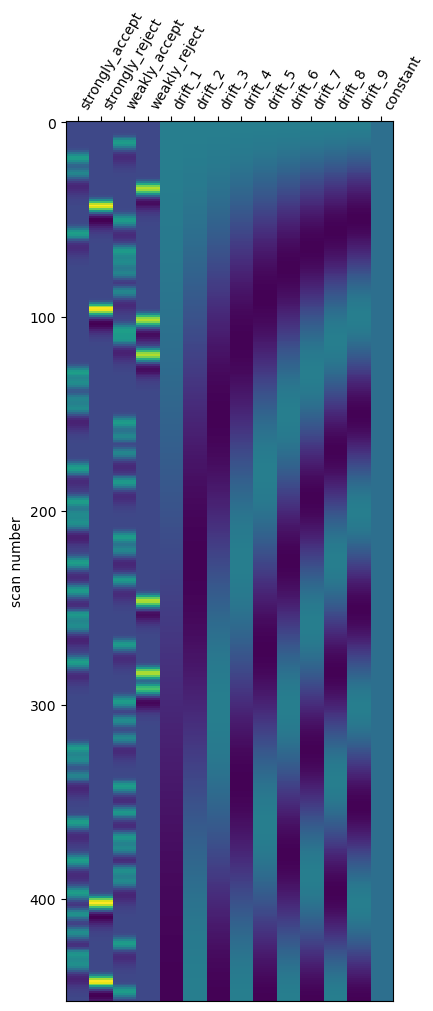

In [8]:
from nilearn.glm.first_level.design_matrix import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

dm_with_drift = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events_dm,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01
)


print("📐 Design matrix shape:", dm_with_drift.shape)
display(dm_with_drift.head())

plot_design_matrix(dm_with_drift)



#### **Understanding the Drift Regressors (The "Noise Cleaning" Columns)**

In our design matrix, we see 9 columns named `drift_1` through `drift_9`. These are not based on the participant's behavior or the screen. They are pure mathematics.

### 1. What are they? (The "Fixed Rulers")

These columns represent a **Discrete Cosine Transform (DCT) Basis Set**.

* **Fixed Values:** The numbers (e.g., `0.066...`) are determined solely by the length of the experiment ( scans). They are standard curves used to model slow, low-frequency noise.
* **The Goal:** We want to separate the **Signal** (Task Activity) from the **Noise** (Scanner Drift, Breathing).

### 2. The Math: How are they computed?

The value for column  at time  is calculated using this trigonometric formula:

* **Normalization ():** This ensures the vector has a standard size. For , this equals , which is why our matrix is filled with values around .
* **Oscillation ():** This creates the wavy shape.

### 3. The Hierarchy: Slow vs. Fast

The index number () tells us the **Frequency** of the wave.

* **`drift_1` ():** The **Slowest** wave. It completes only half a cycle over the entire 8 minutes. It models a simple linear trend (e.g., scanner heating up).
* **`drift_9` ():** A **Faster** wave (relative to drift 1). It completes 4.5 cycles over the experiment. It models slightly faster oscillating noise (e.g., slow breathing cycles).

### 4. Interpretation: What do the Betas mean?

When we run the GLM, it estimates a "Beta weight" for each drift column.

* **High Beta for `drift_1`:** The data has a strong, simple trend (e.g., the signal slowly dropped from start to finish).
* **High Beta for `drift_9`:** The data has a "wavier" background noise.
* **The Result:** The GLM multiplies the Beta by the Drift column and **subtracts** it from the data. This acts as a **High-Pass Filter**, removing the slow waves so we can see the fast brain spikes clearly.

<img src="assets/cosinedrift.png" width="600">


---

#### **Confound regressors: encoding nuisance effects**

### What are confounds?

Confounds are time series that capture **structured sources of noise**, such as:

* head motion (translations and rotations)
* signal outliers
* non–steady-state volumes at run onset

These confounds are typically provided by preprocessing pipelines such as **fMRIPrep**.


### Why include confounds in the design matrix?

Confound regressors allow the design matrix to:

* account for variance unrelated to the task
* reduce contamination of task regressors
* improve separation between signal of interest and noise

⚠️ Confounds are **not experimental hypotheses**.
They are included solely to **absorb unwanted variability**.

In [9]:
confounds = pd.read_csv(conf_path, sep="\t")

confounds2use = confounds[["X", "Y", "Z", "RotX", "RotY", "RotZ", "NonSteadyStateOutlier00"]]

dm_enriched = pd.concat(
    [dm_with_drift, confounds2use],
    axis=1
)

print(dm_enriched.shape)  # (453, P_task + P_drift + P_confounds)
dm_enriched.head()

(906, 21)


,strongly_accept,strongly_reject,weakly_accept,weakly_reject,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,...,drift_8,drift_9,constant,X,Y,Z,RotX,RotY,RotZ,NonSteadyStateOutlier00
0.5,0.0,0.0,0.000000,0.0,0.066445,0.066444,0.066442,0.066439,0.066436,0.066431,...,0.066420,0.066413,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.5,0.0,0.0,0.000000,0.0,0.066442,0.066431,0.066413,0.066388,0.066356,0.066316,...,0.066216,0.066155,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.5,0.0,0.0,0.000000,0.0,0.066436,0.066406,0.066356,0.066286,0.066196,0.066086,...,0.065807,0.065638,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.5,0.0,0.0,0.000000,0.0,0.066426,0.066367,0.066269,0.066133,0.065957,0.065742,...,0.065197,0.064866,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.5,0.0,0.0,0.000003,0.0,0.066413,0.066316,0.066155,0.065929,0.065638,0.065284,...,0.064385,0.063842,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: label='conditions', ylabel='scan number'>

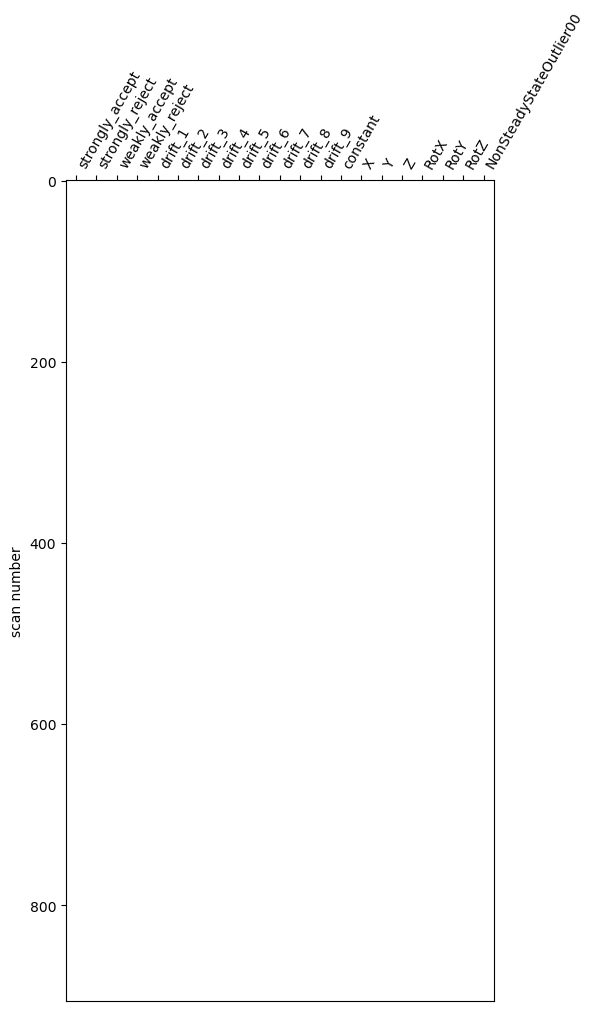

In [10]:
plot_design_matrix(dm_enriched,rescale=True)



---


# Part 7 — First-level GLM (one run, one subject)

## 1. What the first-level GLM is doing

For **each voxel v**, Nilearn fits:

$$
\mathbf{y}_v = X\boldsymbol{\beta}_v + \boldsymbol{\varepsilon}_v
$$

Where:

* $\mathbf{y}_v \in \mathbb{R}^{T}$ = voxel’s BOLD time series (length 453)
* $X \in \mathbb{R}^{T \times p}$ = design matrix (task + drift + confounds + constant)
* $\boldsymbol{\beta}_v \in \mathbb{R}^{p}$ = coefficients for that voxel
* Residuals $\varepsilon$ measure noise not explained by the model

✅ Key point: **Same X for all voxels**, different (y_v) → different betas.

---

## 2. Fit the model (clean + explicit)

### Prepare events


In [11]:
pr_events = events_df[["onset", "duration", "participant_response"]].rename(
    columns={"participant_response": "trial_type"}
)
pr_events["modulation"] = 1.0

events2use = pr_events.query("trial_type != 'NoResp'").copy()

print("📌 events2use shape:", events2use.shape)
print("📌 unique trial types:", events2use["trial_type"].unique())

📌 events2use shape: (63, 4)
📌 unique trial types: ['weakly_accept' 'strongly_accept' 'weakly_reject' 'strongly_reject']


### Prepare confounds


In [12]:
confounds2use = confounds_df[
    ["X", "Y", "Z", "RotX", "RotY", "RotZ", "NonSteadyStateOutlier00"]
].fillna(0)

print("📌 confounds2use shape:", confounds2use.shape)

📌 confounds2use shape: (453, 7)


### Fit

In [13]:
from nilearn.glm.first_level import FirstLevelModel

flm = FirstLevelModel(
    t_r=tr,
    slice_time_ref=0.5,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
    mask_img=mask_path,
    smoothing_fwhm=3.5,
    noise_model="ar1",
    minimize_memory=False,
)

flm.fit(
    run_imgs=fmri_img,
    events=events2use,
    confounds=confounds2use
)

print("✅ GLM fitted!")

[FirstLevelModel.fit] A 'modulation' column was found in the given events data and is used.
✅ GLM fitted!



## 3. Inspect the final design matrix used by the GLM

This is **the design matrix X** that was actually used.

In [14]:
dm_final = flm.design_matrices_[0]
print("📌 dm_final shape:", dm_final.shape)
print("📌 dm_final columns:", list(dm_final.columns))

📌 dm_final shape: (453, 21)
📌 dm_final columns: ['strongly_accept', 'strongly_reject', 'weakly_accept', 'weakly_reject', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ', 'NonSteadyStateOutlier00', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'constant']


What you should see:

* rows = `T = 453`
* columns include:

  * task regressors (`strongly_accept`, `weakly_accept`, etc.)
  * drift regressors (`drift_1 ...`)
  * confounds (`X, Y, Z, RotX, ...`)
  * intercept (`constant`)

And you can plot it:

<Axes: label='conditions', ylabel='scan number'>

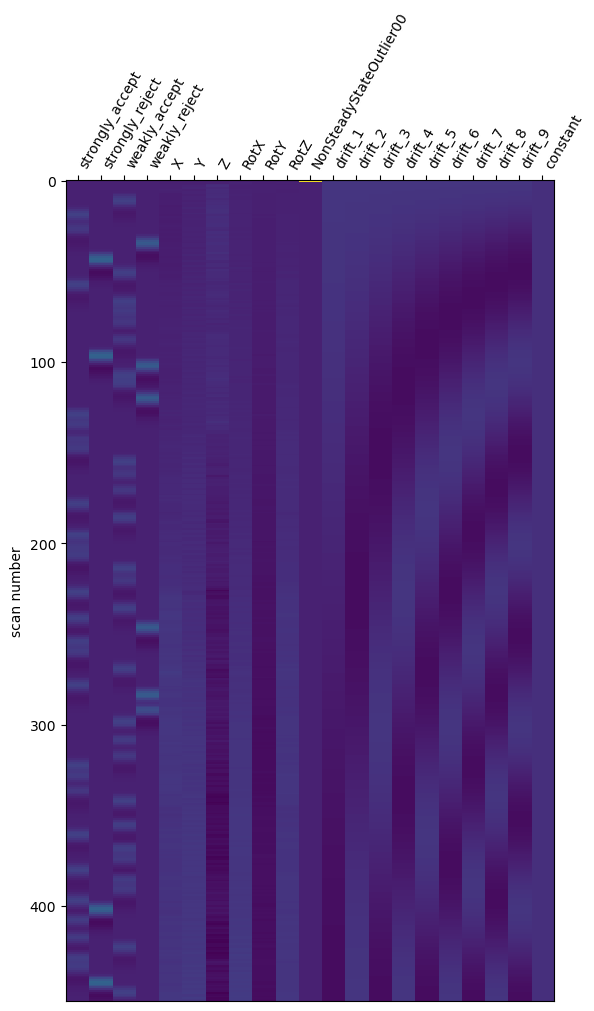

In [15]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(dm_final, rescale=True)

Expected shape:

* a **3D image**: `(nx, ny, nz)` (same spatial shape as the 3D volumes)

---

# 🧠 Part 8 — Computing contrasts

*(From modeled effects to statistical evidence)*

Up to now, we have **fit a General Linear Model (GLM)** independently at each voxel.

In this part, we explain **how a scientific hypothesis is translated into a statistical test**, voxel by voxel.

---

## 1. What exists after fitting the GLM?

Fix **one voxel** $v$.

### Observed data

$$
y_v(t), \quad t = 1,\dots,T
$$

* $y_v(t)$: BOLD signal at voxel $v$ and time point $t$
* $T$: number of fMRI volumes
  (here $T = 453$)


### Design matrix (shared by all voxels)

$$
X \in \mathbb{R}^{T \times p}
$$

* $p$: number of regressors
  (task regressors + drifts + confounds + intercept)



### Estimated regression coefficients

$$
\hat{\boldsymbol{\beta}}_v =
\begin{bmatrix}
\hat{\beta}_{v,1} \\
\hat{\beta}_{v,2} \\
\vdots \\
\hat{\beta}_{v,p}
\end{bmatrix}
$$


**Interpretation**

* one coefficient per regressor
* one vector per voxel
* across voxels, each regressor corresponds to a **3D beta map**

> Each $\hat{\beta}_{v,j}$ answers:
> *“How strongly does voxel $v$ follow regressor $j$ over time?”*



## 2. What is a contrast?

A **contrast** is a linear combination of regression coefficients.

It is defined by a vector:
$$
c \in \mathbb{R}^p
$$

* one weight per regressor
* encodes the **hypothesis being tested**


### Contrast estimate (voxelwise)

$$
\hat{\theta}_v = c^\top \hat{\boldsymbol{\beta}}_v
$$

#### Parameters

* $v$: voxel index
* $c$: contrast vector
* $\hat{\boldsymbol{\beta}}_v$: beta vector at voxel $v$
* $\hat{\theta}_v$: **scalar effect** at voxel $v$



### Interpretation

* $\hat{\theta}_v$ is **one number per voxel**
* across voxels, it forms a **3D contrast image**

> A contrast **summarizes multiple betas into a single effect of interest**, voxel by voxel.



## 3. Example: Reject > Accept (averaging decision strength)

### Scientific question

> *Is this voxel more active during rejection than acceptance, regardless of strength?*



### Contrast definition

Reject average:
$$
\frac{1}{2}
\left(
\hat{\beta}_{v,\text{strongly reject}}
+
\hat{\beta}_{v,\text{weakly reject}}
\right)
$$

Accept average:
$$
\frac{1}{2}
\left(
\hat{\beta}_{v,\text{strongly accept}}
+
\hat{\beta}_{v,\text{weakly accept}}
\right)
$$



### Contrast estimate

$$
\hat{\theta}_v =
\frac{1}{2}
\left(
\hat{\beta}_{v,\text{strongly reject}}
+
\hat{\beta}_{v,\text{weakly reject}}
\right)
-
\frac{1}{2}
\left(
\hat{\beta}_{v,\text{strongly accept}}
+
\hat{\beta}_{v,\text{weakly accept}}
\right)

$$




### Interpretation of $\hat{\theta}_v$

* $\hat{\theta}_v > 0$: stronger response for **reject**
* $\hat{\theta}_v < 0$: stronger response for **accept**
* $\hat{\theta}_v \approx 0$: no difference

⚠️ At this stage, this is **not yet statistical evidence** — only an **effect size**.



## 4. Why effect size is not enough

Two voxels may have the same $\hat{\theta}_v$, but:

* one voxel is stable
* the other is very noisy

We must ask:

> *Is this effect large compared to the noise at this voxel?*

This leads to **residuals, variance, and the t-statistic**.



## 5. Residuals: prediction error

$$
\varepsilon_v(t) = y_v(t) - \hat{y}_v(t)
$$

#### Parameters

* $y_v(t)$: observed BOLD signal
* $\hat{y}_v(t)$: model prediction
* $\varepsilon_v(t)$: unexplained signal



### Interpretation

Residuals measure **everything the model failed to explain** at voxel $v$:

* physiological noise
* scanner noise
* unmodeled brain activity



## 6. Voxel-specific noise variance

$$
\hat{\sigma}_v^2
=

\frac{1}{T - p}
\sum_{t=1}^{T} \varepsilon_v(t)^2
$$

### Parameters explained

* $T$: number of time points
* $p$: number of estimated parameters
* $T - p$: degrees of freedom
* $\hat{\sigma}_v^2$: noise variance at voxel $v$



### Why divide by $T - p$?

Each estimated parameter consumes one degree of freedom.
This correction prevents **underestimating noise**.



### Intuition (critical)

> Voxels with large unexplained fluctuations get a **large noise variance**.
> Noisy voxels are automatically **penalized** later.



## 7. Standard error of the contrast

$$
SE(\hat{\theta}_v)
=
\sqrt{
\hat{\sigma}_v^2 \; c^\top (X^\top X)^{-1} c
}

$$

### Meaning of each term

* $\hat{\sigma}_v^2$: voxel noise
* $(X^\top X)^{-1}$: regressor correlations
* $c$: contrast geometry


### Interpretation

> How much would $\hat{\theta}_v$ vary if we repeated the experiment?



## 8. The t-statistic: effect relative to noise

$$
t_v
=

\frac{\hat{\theta}_v}{SE(\hat{\theta}_v)}
$$

### Interpretation

* numerator: effect size
* denominator: uncertainty

> **$t = \text{signal} / \text{noise}$**



### Why noisy voxels are penalized

If a voxel is noisy:

* $\hat{\sigma}_v^2$ is large
* $SE(\hat{\theta}_v)$ is large
* $t_v$ becomes small

Even a large raw effect will not be significant if it is unreliable.


## 9. From t-map to z-map

Nilearn computes $t_v$ for every voxel and converts it to a z-score:

$$
z_v = \Phi^{-1}(P(T \le t_v))
$$

This produces a **standard normal statistic**, easier to threshold and compare.



## 10. Computing the contrast in Nilearn

In [ ]:
reject_gt_accept = flm.compute_contrast(
    "0.5*(strongly_reject + weakly_reject) - 0.5*(strongly_accept + weakly_accept)",
    stat_type="t",
    output_type="z_score",
)

print(type(reject_gt_accept))
print(reject_gt_accept.shape)




### Output

* a **3D NIfTI image**
* one z-value per voxel
* one statistical test per voxel


## 11. Interpreting the z-map

* $z > 0$: reject > accept
* $z < 0$: accept > reject
* $|z|$ large: strong evidence against the null hypothesis

⚠️ This map is **not yet corrected for multiple comparisons**.



# 🧠 Part 9 — Model quality and inference



## 1. Why model diagnostics matter

A statistically significant voxel is meaningful **only if the model fits the data**.

## 2. Voxelwise coefficient of determination

$$
R_v^2
=
1 -
\frac{
\sum_t (y_v(t) - \hat{y}_v(t))^2
}{
\sum_t (y_v(t) - \bar{y}_v)^2
}

$$



In [ ]:
r2_img = flm.r_square[0]

plotting.plot_stat_map(
    r2_img,
    title="Voxelwise R² (model fit diagnostic)",
    threshold=0.1
)


### Interpretation

* high $R_v^2$: model explains the voxel well
* low $R_v^2$: mostly noise

📌 $R^2$ is **diagnostic**, not inferential.



## 3. Multiple-comparison correction

A z-map contains **thousands of voxelwise tests**.
We must control false positives.

### False Discovery Rate (recommended)


In [ ]:
from nilearn.glm.thresholding import threshold_stats_img

zmap_thr, zthr = threshold_stats_img(
    reject_gt_accept,
    alpha=0.05,
    height_control="fdr"
)

print("📌 FDR z-threshold used:", zthr)

plotting.plot_stat_map(
    zmap_thr_fdr,
    title=f"Reject > Accept (FDR q<0.05, z>{zthr:.2f})"
)


## 4. Final interpretation

After correction:

* surviving voxels = statistically reliable effects
* interpretation is valid at the chosen error rate

---

## 🧠 Final takeaway (for students)

> A contrast tests whether a voxel’s modeled effect is large **relative to its own noise**, and valid inference requires correcting for the many voxelwise tests performed.

If you want, next we can:

* add a **tiny numerical toy example**
* build a **one-slide summary diagram**
* or convert this into a **spoken 2-minute explanation**
